In [17]:
import pandas as pd

df_text = pd.read_csv('data/tweets_corregidos.csv')

In [ ]:
#!curl -L -o glove6b100dtxt.zip https://www.kaggle.com/api/v1/datasets/download/danielwillgeorge/glove6b100dtxt && unzip glove6b100dtxt.zip && rm glove6b100dtxt.zip

In [19]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10124 entries, 0 to 10123
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Twitter  10124 non-null  object
 1   NPS      10124 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 158.3+ KB


In [20]:
df_text.head()

,Twitter,NPS
0,ok i am loving this,2
1,i hate the mobile app it doesnt work very well,0
2,ok i am loving this,2
3,appreciated you attention in the contact center,2
4,appreciate the conversations and actions broug...,2


In [21]:
df_text['NPS'].value_counts()

NPS
2    5926
1    3083
0    1115
Name: count, dtype: int64

In [22]:
import numpy as np
import re
import nltk
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from nltk import pos_tag, ngrams
from tqdm import tqdm
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer


# --- NLTK ---
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
try:
    nltk.download('averaged_perceptron_tagger_eng')
except:
    nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-záéíóúüñ ]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize_and_lemmatize(series):
    from nltk import pos_tag
    all_tokens = []
    for text in tqdm(series, desc="Tokenizing & Lemmatizing"):
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
        pos_tags = pos_tag(tokens, lang='eng')
        lemmas = [lemmatizer.lemmatize(t, get_wordnet_pos(pos)) for t, pos in pos_tags]
        all_tokens.append(lemmas)
    return all_tokens


# --- Preparar texto ---
df_cleaned = df_text.dropna()
df_cleaned['Twitter'] = df_text['Twitter'].apply(clean_text)

# Ejemplo: suponiendo que df_cleaned tiene la columna NPS como target
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df_cleaned['Twitter'], df_cleaned['NPS'], test_size=0.2, random_state=42
)

# --- Cargar GloVe ---
glove_path = 'glove.6B.100d.txt'
glove = {}
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove[word] = vector


# --- Función para obtener embeddings (con bigramas/trigramas) ---
def get_embeddings(train_col, test_col, glove, use_bigrams=True, use_trigrams=True):

    # --- Tokenización, lematización y generación de n-grams ---
    def process_series(series):
        tokenized = []
        for text in tqdm(series, desc="Tokenizing + Lemmatizing + N-grams"):
            tokens = word_tokenize(text)
            tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
            pos_tags = pos_tag(tokens, lang='eng')
            lemmas = [lemmatizer.lemmatize(t, get_wordnet_pos(pos)) for t, pos in pos_tags]

            # Agregar bigramas y trigramas
            ngram_tokens = lemmas.copy()
            if use_bigrams:
                ngram_tokens.extend(['_'.join(bg) for bg in ngrams(lemmas, 2)])
            if use_trigrams:
                ngram_tokens.extend(['_'.join(tg) for tg in ngrams(lemmas, 3)])

            tokenized.append(ngram_tokens)
        return tokenized

    train_tokens = process_series(train_col)
    test_tokens  = process_series(test_col)

    # --- Word2Vec ---
    w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4)
    def avg_vector(tokens, model):
        vecs = [model.wv[w] for w in tokens if w in model.wv]
        return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)
    X_train_w2v = np.array([avg_vector(t, w2v_model) for t in train_tokens])
    X_test_w2v  = np.array([avg_vector(t, w2v_model) for t in test_tokens])

    # --- GloVe ---
    def avg_glove(tokens, glove_model):
        vecs = [glove_model[w] for w in tokens if w in glove_model]
        return np.mean(vecs, axis=0) if vecs else np.zeros(100)
    X_train_glove = np.array([avg_glove(t, glove) for t in train_tokens])
    X_test_glove  = np.array([avg_glove(t, glove) for t in test_tokens])

    # --- SBERT ---
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
    X_train_sbert = sbert_model.encode(train_col.tolist(), batch_size=32, show_progress_bar=True)
    X_test_sbert  = sbert_model.encode(test_col.tolist(), batch_size=32, show_progress_bar=True)

    return X_train_w2v, X_test_w2v, X_train_glove, X_test_glove, X_train_sbert, X_test_sbert


X_train_w2v, X_test_w2v, X_train_glove, X_test_glove, X_train_sbert, X_test_sbert = \
    get_embeddings(X_train_text, X_test_text, glove)

print("✅ Embeddings generados:")
print("Word2Vec:", X_train_w2v.shape)
print("GloVe:", X_train_glove.shape)
print("SBERT:", X_train_sbert.shape)


[nltk_data] Downloading package punkt to /home/ariel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ariel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ariel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/ariel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
Batches: 100%|██████████| 64/64 [00:00<00:00, 174.07it/s]

✅ Embeddings generados:
Word2Vec: (8099, 100)
GloVe: (8099, 100)
SBERT: (8099, 384)


In [23]:
import gc
gc.collect()

5420

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

# Convert labels to one-hot
num_classes = len(np.unique(y_train))
y_train_cat = np.eye(num_classes)[y_train]
y_test_cat = np.eye(num_classes)[y_test]

class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(8, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.softmax(self.fc2(x), dim=1)
        return x
def train_model_metrics(X_train, y_train_cat, X_test, y_test_cat, name):
    input_dim = X_train.shape[1]
    output_dim = y_train_cat.shape[1]
    
    model = SimpleNN(input_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_cat, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_cat, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    patience = 5
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(30):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.argmax(dim=1))
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            outputs = model(X_test_tensor)
            val_loss = criterion(outputs, y_test_tensor.argmax(dim=1)).item()

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            model.load_state_dict(best_model_state)
            break

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        y_pred = outputs.argmax(dim=1).numpy()
        y_true = y_test_tensor.argmax(dim=1).numpy()
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    
    return model, acc, f1, cm, y_pred

model_w2v, acc_w2v, f1_w2v, cm_w2v, y_pred_w2v = train_model_metrics(
    X_train_w2v, y_train_cat, X_test_w2v, y_test_cat, "Word2Vec"
)
model_glove, acc_glove, f1_glove, cm_glove, y_pred_glove = train_model_metrics(
    X_train_glove, y_train_cat, X_test_glove, y_test_cat, "GloVe"
)
model_sbert, acc_sbert, f1_sbert, cm_sbert, y_pred_sbert = train_model_metrics(
    X_train_sbert, y_train_cat, X_test_sbert, y_test_cat, "SBERT"
)

print("Word2Vec -> Accuracy:", acc_w2v, "F1:", f1_w2v)
print("GloVe     -> Accuracy:", acc_glove, "F1:", f1_glove)
print("SBERT     -> Accuracy:", acc_sbert, "F1:", f1_sbert)

Word2Vec -> Accuracy: 0.9817283950617284 F1: 0.98107896051999
GloVe     -> Accuracy: 0.9911111111111112 F1: 0.9909627231487222
SBERT     -> Accuracy: 0.9965432098765432 F1: 0.9965278280368051


In [25]:
gc.collect()

8

In [26]:
torch.save(model_w2v.state_dict(), "models/2/Word2Vec.pt")
torch.save(model_glove.state_dict(), "models/2/GLOVE.pt")
torch.save(model_sbert.state_dict(), "models/2/SBERT.pt")


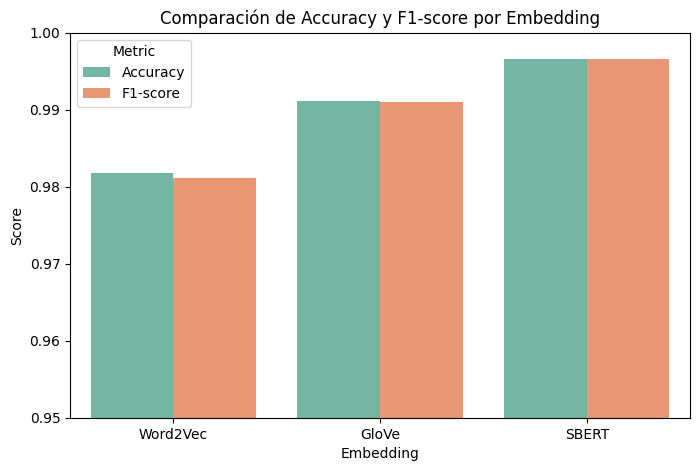

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_metrics_comparison(acc_dict, f1_dict):
    df = pd.DataFrame({
        'Embedding': list(acc_dict.keys()) * 2,
        'Metric': ['Accuracy']*len(acc_dict) + ['F1-score']*len(f1_dict),
        'Value': list(acc_dict.values()) + list(f1_dict.values())
    })

    plt.figure(figsize=(8,5))
    sns.barplot(x='Embedding', y='Value', hue='Metric', data=df, palette='Set2')
    plt.ylim(0.95,1)
    plt.title("Comparación de Accuracy y F1-score por Embedding")
    plt.ylabel("Score")
    plt.show()

# --- Usar la función con tus métricas ---
acc_dict = {'Word2Vec': acc_w2v, 'GloVe': acc_glove, 'SBERT': acc_sbert}
f1_dict  = {'Word2Vec': f1_w2v, 'GloVe': f1_glove, 'SBERT': f1_sbert}

plot_metrics_comparison(acc_dict, f1_dict)

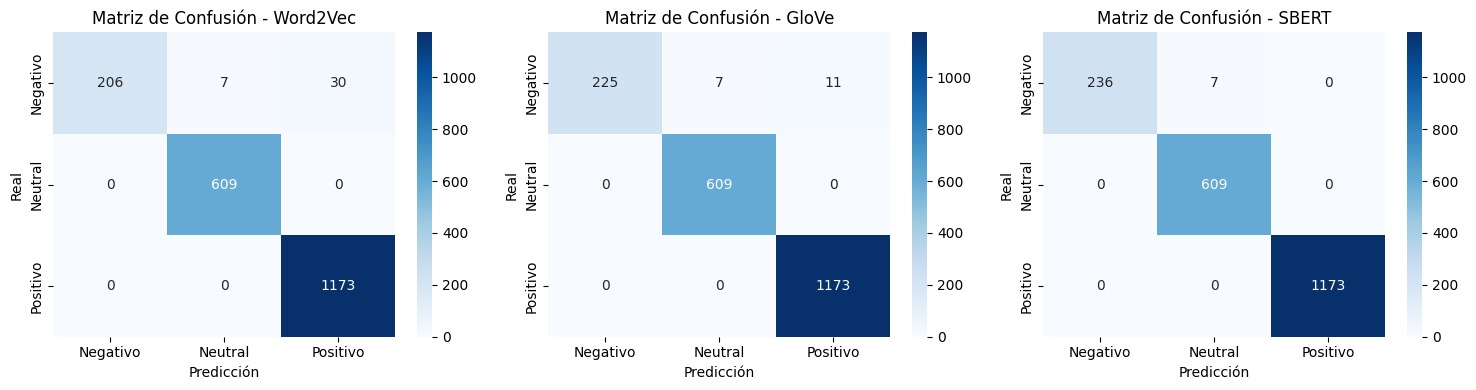

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(y_true, preds_dict, labels):
    
    n = len(preds_dict)
    plt.figure(figsize=(5*n, 4))
    
    for i, (name, y_pred) in enumerate(preds_dict.items(), 1):
        cm = confusion_matrix(y_true, y_pred)
        plt.subplot(1, n, i)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title(f"Matriz de Confusión - {name}")
        plt.xlabel("Predicción")
        plt.ylabel("Real")
    
    plt.tight_layout()
    plt.show()

# --- Ejemplo de uso ---
preds_dict = {
    'Word2Vec': y_pred_w2v,
    'GloVe': y_pred_glove,
    'SBERT': y_pred_sbert
}

# Ajusta los nombres según tu codificación
labels = ['Negativo', 'Neutral', 'Positivo']

plot_confusion_matrices(y_test, preds_dict, labels)

In [29]:
gc.collect()

17454

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


rf = RandomForestClassifier(
    n_estimators=10,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

print("🌲 Entrenando Random Forest...")
rf.fit(X_train_sbert, y_train)

# --- Predicciones ---
y_pred = rf.predict(X_test_sbert)

# --- Resultados ---
print("\n✅ Evaluación del modelo:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

🌲 Entrenando Random Forest...

✅ Evaluación del modelo:
Accuracy: 1.0

Confusion Matrix:
[[ 243    0    0]
 [   0  609    0]
 [   0    0 1173]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      1.00      1.00       609
           2       1.00      1.00      1.00      1173

    accuracy                           1.00      2025
   macro avg       1.00      1.00      1.00      2025
weighted avg       1.00      1.00      1.00      2025

